# Recommender System with Book Rating Data

In this notebook, we focuses on visualizing the book rating data

### Data Visualization and Exploratory Analysis

#### Load library
We start by loading some libraries

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
import json
from pandas.io.json import json_normalize

#### Read data

We read three datafiles as dataframes. Where

*'BX-CSV-Dump/book-crossing_users.json'* has the user information <br />
*'BX-CSV-Dump/book-crossing_books.json'* has the book information <br />
*'BX-CSV-Dump/book-crossing_explicit_ratings.json'* has the users' ratings on books <br />

The describtions of the dataset can be found [Here](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)

In [52]:
# Import Users file as dataframe
with open('BX-CSV-Dump/book-crossing_users.json') as data_file:
    data = data_file.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
User = pd.read_json(data_json_str)

In [53]:
# Import Books file as dataframe
with open('BX-CSV-Dump/book-crossing_books.json') as data_file:
        data = data_file.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
Books = pd.read_json(data_json_str)

In [54]:
# Import Ratings file as dataframe
# Note that duplicate entries of ratings have already been removed
# Also users who do not rate at least one book has been removed
# Books not receiving as least one review have been removed from rating matrix
# Only Explicit Ratings are loaded and analysed
with open('BX-CSV-Dump/book-crossing_explicit_ratings.json') as data_file:
        data = data_file.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
df = pd.read_json(data_json_str)

#### Have a look at the dataset

First, let's have a look at the dataset. Dataframe **df** contains users' ratings of books (a total of 383852 ratings, for 149842 books, from 68092 users). <br />

While dataframe **Books** contains more information on the books such as title, autor, year and publisher. 

The dataframe **User** has other user information, such as location and age <br />

Here we print out heads of ratings, Books, and User dataframe 

##### Number of books and number of users

In [55]:
# Get Number of Users and Number of Books
n_users = df.user_id.nunique()
n_books = df.book_id.nunique()

In [56]:
# Group the books and their ratings in the dataframe ratings
sns.set_style('white')
ratings = pd.DataFrame(df.groupby('book_id')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('book_id')['rating'].count())

#### Q1: What is the number of ratings per user?

Most of the users only give one rating. The number of ratings per user seems to exponentially decaying. The users who only rate 1 or 2 books do not provide much information on recommending. So I will filter out these users have less than 3 ratings later.

In [57]:
userrating = pd.DataFrame(columns=['num of ratings'])
userrating['rating'] = df.groupby('user_id')['rating'].mean()
userrating['num of ratings'] = df.groupby('user_id')['rating'].count()

The maximum number of ratings from one user is: 6943
The minimum number of ratings from one user is: 4


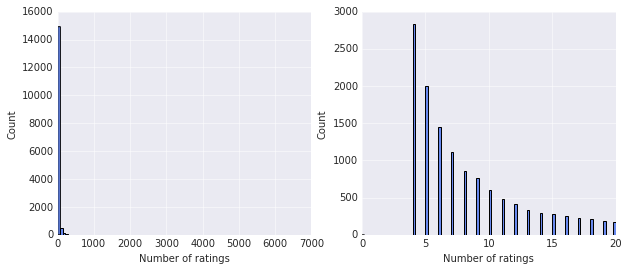

In [64]:
nummax = userrating['num of ratings'].max()
nummin = userrating['num of ratings'].min()
print('The maximum number of ratings from one user is: ' + str(nummax))
print('The minimum number of ratings from one user is: ' + str(nummin))
# Visualize users and their ratings
# Plot the count of number of ratings from all users
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.set_xlabel('Number of ratings')
ax1.set_ylabel('Count')
hist1 = ax1.hist(x = userrating['num of ratings'], bins =100)
ax2.set_xlabel('Number of ratings')
ax2.set_ylabel('Count')
hist2 = ax2.hist(x = userrating['num of ratings'], bins =100, range=(0,20))

#### Q4: Distribution of mean user ratings
Most of the ratings fall between 6 to 9. Still there are peaks at ratings = integer because there are many users who only give one rating. 

#### Filter out the users with less than 4 rating

People have different tendencies to rate books. Some already give 10 to a mediocre book, while others do not give 10 unless it is the perfect book for them. Such tendencies can be seen in the figure below. On the right side there is a bump from users with a mean rating of 10, indicating that they really liked all books (or they only rated books they really like…). We can also see that there are nearly no notoriuous downvoters rating all books with a 1. Such tendencies are going to be important for collaborative filtering later, and are typically dealt with by subtracting the user’s mean rating from their ratings.

In [59]:
userrating = userrating[userrating['num of ratings'] > 3]

(-10, 500)

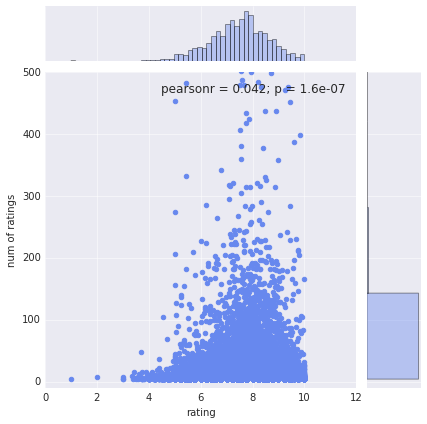

In [60]:
sns.set_style('darkgrid')
sns.set_palette('coolwarm')
sns.jointplot(x='rating',y='num of ratings',data=userrating)
plt.ylim((-10,500))

In [62]:
ratings['book_id'] = ratings.index
book_ratings = Books.merge(ratings, on='book_id');

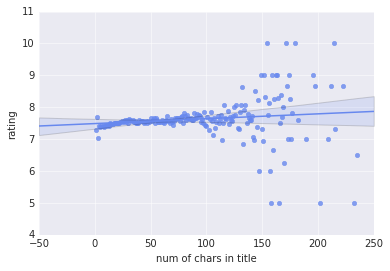

In [63]:
book_ratings['num of chars in title'] = Books.merge(ratings, on='book_id')['title'].apply(lambda x: len(x.replace(" ", "")))
df2=book_ratings[['num of chars in title', 'rating']].groupby(['num of chars in title']).mean().reset_index()
sns.regplot(x = 'num of chars in title', y ='rating', data = df2)